# Libraries and loading in the data

In [4]:
import xarray as xr
import os
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client
from dask import config as dask_config
import pandas as pd

In [5]:
plt.style.use('/Users/kyle/GoogleDrive/personal.mplstyle')

In [6]:
dask_config.set(temporary_directory='/tmp')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:49667 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 32.00 GiB


In [7]:
client.cluster

In [8]:
xr.set_options(keep_attrs=True)
pd.options.display.float_format = '{:.2f}'.format

In [9]:
with xr.open_dataset(os.path.join('data', 'MERRA-2', 'Texas', 'merged-all-products-daily-averages-clipped.nc4')) as ds:
    ds.load()

ds['PM2.5'] = np.log(ds['PM2.5'] * 1e9)
ds['AODANA'] = np.log(ds['AODANA'])
ds

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/117)
    LWGAB        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    CLDTOT       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ALBNIRDF     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SWTDN        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    LWTUPCLRCLN  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    HOURNORAIN   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMAX       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMEAN      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMIN       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

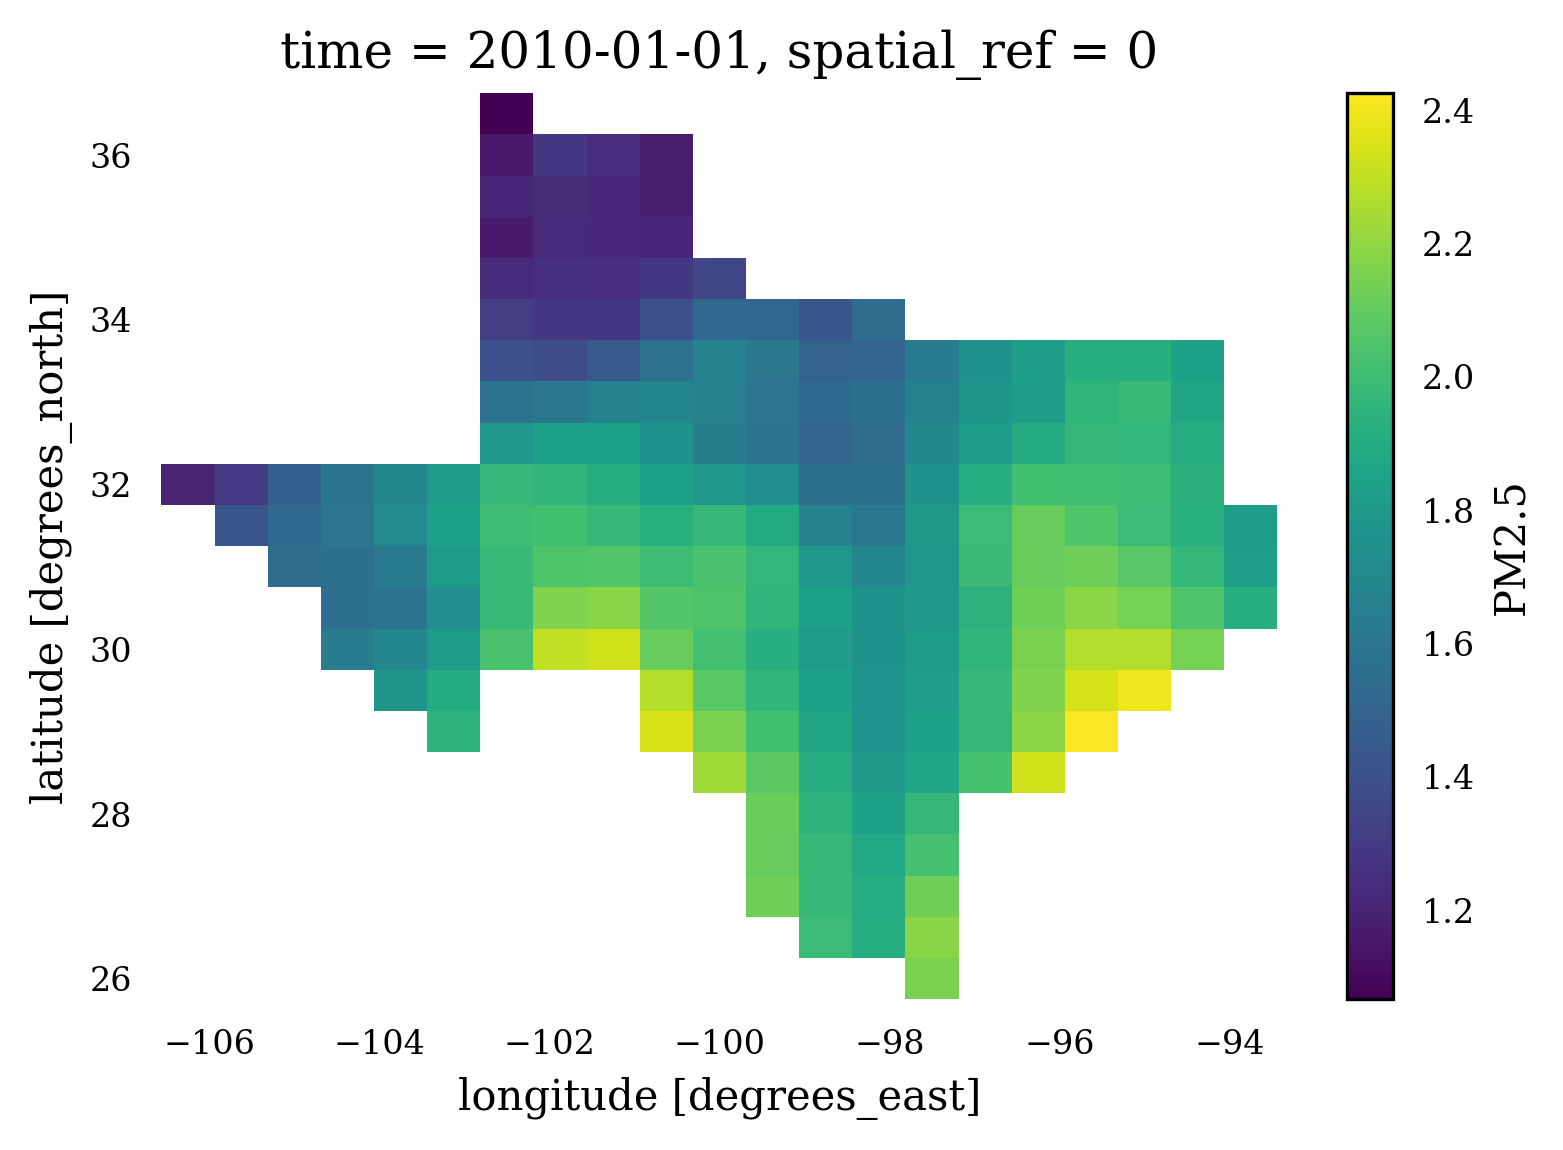

In [10]:
fig, ax = plt.subplots(dpi=300)

ds["PM2.5"][0].plot(ax=ax)

In [11]:
ds['MonthCos'] = np.cos(np.pi * 2 * ds.time.dt.month / 12)
ds['MonthSin'] = np.sin(np.pi * 2 * ds.time.dt.month / 12)

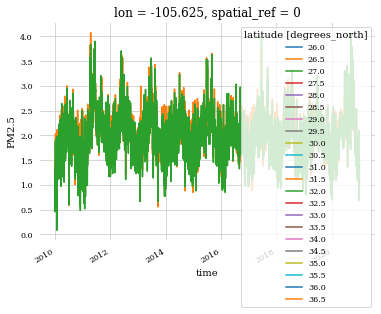

In [12]:
plt.rcParams.update({
    "text.usetex": False
})
ds['PM2.5'].isel(lon=1).plot.line(x='time');

In [55]:
for feature in features_to_keep:
    if feature not in ['PM2.5', 'MonthSin', 'MonthCos']:
        print(feature, ds[feature].attrs['long_name'])

PS surface_pressure
QV2M 2-meter_specific_humidity
QV10M 10-meter_specific_humidity
T2M 2-meter_air_temperature
T10M 10-meter_air_temperature
U2M 2-meter_eastward_wind
V2M 2-meter_northward_wind
U50M eastward_wind_at_50_meters
V50M northward_wind_at_50_meters
U10M 10-meter_eastward_wind
V10M 10-meter_northward_wind
TQL total_precipitable_liquid_water
TQI total_precipitable_ice_water
TQV total_precipitable_water_vapor
CLDTOT total_cloud_area_fraction
AODANA Aerosol Optical Depth Analysis
ALBEDO surface_albedo
TS surface_skin_temperature
TPRECMAX total_precipitation
DISPH zero_plane_displacement_height
EMIS surface_emissivity


# Feature Selection

120 features is far too many features. Further, some of the columns make up the PM2.5 column and many are not directly measurable by ground stations. The goal of this project is to work on data reminiscent of ground data and then compare the performance of several of the algorithms across the same time and spatial domain with the same features. A future study could then replicate the results but with data measured with satellites and weather stations.

Here, we will pick out a subset of the variables which are directly measurable and then choose the top `n` features with the highest mutual information value. There is no fundamental reason that we chose mutual information over Pearson's R.

First we will need to cut down the data to those columns that we need, split into the testing, training, and validation sets, and then run feature selection. The feature selection will be run only on the training set. The columns kept from the training set will be applied to the validation and testing sets.

A note on the train, test, validation split: The atmosphere has a memory. One can imagine that the concentration of PM2.5 on a Monday might affect the concentration on a Tuesday. Similar things can be said for other data variables. I do not know how, but it is possible that somehow some of the algorithms could learn a correlation between these variables, depending on which time componenet is used. To prevent the learned estimators from cheating when predicting the testing data, I wanted to ensure that there was space in time between the training and testing sets. That is why I did not use the normal `train_test_split` function provided by `scikit-learn`. Further, the validation set here is used only to check the out-of-sample performance **after** the algorithms are trained, meaning this validation set is not used in any of the algorithms. It is possible that some of the algorithms use a validation set, but that set would be a subset of the training set. Because the validation set made here is used to check the out-of-sample performance, it is possible that some of the actions taken could be influenced by those values, so the validation set should be considered to be a part of the training set. The final values reported at the end of this study will be reported on the testing set. The testing set will be run *exactly* once.

In [13]:
features_to_keep = [
    'PS',
    'QV2M',
    'QV10M',
    'T2M',
    'T10M',
    'U2M',
    'V2M',
    'U50M',
    'V50M',
    'U10M',
    'V10M',
    'TQL',
    'TQI',
    'TQV',
    'CLDTOT',
    'PM2.5',
    'AODANA',
    'ALBEDO',
    'TS',
    'MonthSin',
    'MonthCos',
    'TPRECMAX',
    'DISPH',
    'EMIS'
    ]

In [14]:
df = ds[features_to_keep]
df

<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/24)
    PS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV2M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T10M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    U2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    TS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    DISPH        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [15]:
train = df.sel(time=slice("2010", "2017")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
val = df.sel(time=slice("2018", "2019-06")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
test = df.sel(time=slice("2019-07", "2020")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)

In [16]:
client.close()

Because the dataset was clipped to Texas, there are a lot of NaNs. We can just drop those since those are for location that are not in Texas.


In [17]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
train.head()

,lat,lon,PS,QV2M,QV10M,T2M,T10M,U2M,V2M,U50M,...,CLDTOT,PM2.5,AODANA,ALBEDO,TS,MonthSin,MonthCos,TPRECMAX,DISPH,EMIS
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,26.00,-97.50,102550.84,0.01,0.01,286.15,286.14,1.17,-4.50,1.90,...,0.70,2.15,-2.30,0.17,286.53,0.50,0.87,0.00,0.17,0.97
2010-01-02,26.00,-97.50,102471.00,0.01,0.01,285.52,286.11,-1.47,-0.55,-2.82,...,0.77,1.83,-2.17,0.16,285.80,0.50,0.87,0.00,0.17,0.97
2010-01-03,26.00,-97.50,101837.12,0.01,0.01,289.48,289.97,-0.82,0.06,-2.22,...,0.84,1.98,-1.76,0.16,289.42,0.50,0.87,0.00,0.17,0.97
2010-01-04,26.00,-97.50,102421.00,0.01,0.01,287.70,287.63,-0.90,-4.72,-1.78,...,0.87,2.66,-1.52,0.16,288.01,0.50,0.87,0.00,0.17,0.97
2010-01-05,26.00,-97.50,102816.41,0.01,0.01,284.08,284.30,-1.30,-2.23,-2.58,...,0.61,2.00,-2.10,0.17,284.90,0.50,0.87,0.00,0.17,0.97


In [18]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

def make_feature_selector(df, endogenous, k=15):
    """ Create a SelectKBest model for the dataset
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe holding the exogenous (independent) and endogenous (dependent) variables
    endogenous: str
        A string indicating which variable is the endogenous (dependent) variable
    k: int, default 15
        The number of desired features (columns of the dataframe, exogenous variables) to keep

    Returns
    ----------
    features: sklearn.feature_selection.SelectKBest
        A fitted SelectKBest model
    """
    X, y = df.drop(endogenous, axis=1), df[endogenous]
    features = SelectKBest(mutual_info_regression, k=k)
    features.fit(X, y)
    return features

def subset_features(df, features):
    """ Extract the desired features from a dataframe
    
    Parameters
    ----------
    df : a pandas dataframe
        The dataframe holding the exogenous (independent) variables and excluding the endogenous (dependent) variable
    features: sklearn.feature_selection._BaseFilter
        A fitted sklearn.feature_selection._BaseFilter like SelectKBest

    Returns
    ----------
    X: pandas.DataFrame
        A subset of `df` containing only those features selected by `features`
    """
    
    return df.loc[:, features.get_support()]

In [19]:
import pickle

load = True

if load:
    with open('models/feature_selection_lod_aod.pcl', 'rb') as f:
        features = pickle.load(f)
else:
    features = make_feature_selector(train, 'PM2.5', k=10)
    with open('models/feature_selection_lod_aod.pcl', 'wb') as f:
        pickle.dump(features, f)

In [20]:
x_train, y_train = subset_features(train.drop('PM2.5', axis=1), features), train['PM2.5']

In [21]:
x_val, y_val = subset_features(val.drop('PM2.5', axis=1), features), val['PM2.5']

In [22]:
x_test, y_test = subset_features(test.drop('PM2.5', axis=1), features), test['PM2.5']

# Utility

In [23]:
def summarize_scores(scores):
    r2 = scores["test_r2"].mean()
    mae = np.abs(scores["test_neg_mean_absolute_error"]).mean()
    rmse = np.abs(scores["test_neg_root_mean_squared_error"]).mean()
    return r2, mae, rmse
    
def print_scores(scores):
    r2, mae, rmse = summarize_scores(scores)
    
    print('R2, MAE, RMSE')
    print(f'{r2:.2f}, {mae:.2f}, {rmse:.2f}')
    
def size_in_bytes(df):
    return df.values.nbytes + df.index.nbytes + df.columns.nbytes

def size_in_kilobytes(df):
    return size_in_bytes(df) / 1024

def size_in_megabytes(df):
    return size_in_bytes(df) / 1024 ** 2

# Plotting

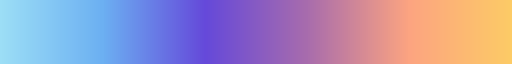

In [24]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)
announce

In [25]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import contextily as cx

from yellowbrick.regressor import ResidualsPlot

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

import scipy.stats as stats

def residuals_plot(model, x, y, unseen_x, unseen_y, unseen_label = 'Validation', train_color='#9CDEF6', test_color='#6549DA'):
    fig, ax = plt.subplots(dpi=300)
    x_test = unseen_x.copy()

    visualizer = ResidualsPlot(model, ax=ax, hist=False, qqplot=True, 
                              train_alpha=0.5, 
                              test_alpha=0.5,
                              train_color=train_color,
                              test_color=test_color,
                              is_fitted=True)

    visualizer.fit(x, y)  # Fit the training data to the visualizer
    visualizer.score(x_test, unseen_y)  # Evaluate the model on the test data

    for _ax in fig.get_axes():
        _ax.tick_params(axis='both', labelsize=10, width=0, which='both')
        _ax.grid(True, alpha=0.2)

    visualizer._labels = [i.replace('Test', unseen_label) for i in visualizer._labels]
    visualizer.show()    

def score_boxplot(score_type, *args, title='', labels=None, ax=None, tick_fontsize=10, title_fontsize=20, take_absolute_value=False):
    if labels is None:
        raise ValueError("Provide labels")
    scores = [arg[score_type] for arg in args]
    
    if take_absolute_value:
        scores = list(map(np.abs, scores))
    
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    
    boxes = ax.boxplot(scores, labels=labels, vert=False, showmeans=True)
    
    ax.set_title(title, fontsize=title_fontsize)
    
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.5)
    
    return boxes

def grouped_boxplot_with_table(scores, labels, save=False, filename='scores.png', fs=10):
    fig = plt.figure(figsize=(10, 5.0), dpi=300)

    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :])

    r2_boxes = score_boxplot('test_r2', *scores, 
                  title='$R^2$', labels=labels, ax=ax1, 
                  tick_fontsize=fs)

    mae_boxes = score_boxplot('test_neg_mean_absolute_error', *scores, 
                  title='MAE', labels=labels, ax=ax2, 
                  tick_fontsize=fs, take_absolute_value=True)

    rmse_boxes = score_boxplot('test_neg_root_mean_squared_error', *scores, 
                  title='RMSE', labels=labels, ax=ax3, 
                  tick_fontsize=fs, take_absolute_value=True)

    for boxes in [r2_boxes, mae_boxes, rmse_boxes]:
        for mean in boxes['means']:
            mean.set_markerfacecolor('#A86CAD')
        for median in boxes['medians']:
            median.set_color('#FCA481')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

    ax2.set_yticklabels([])
    ax3.set_yticklabels([])

    plt.rc('text', usetex=True)
    ax2.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)
    ax3.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)

    ax4.axis('off')
    ax4.axis('tight')

    cell_text = []
    for score in scores:
        vals = [f'{i:.2f}' for i in summarize_scores(score)]
        cell_text.append(vals)

    table = ax4.table(cellText=cell_text,
                          rowLabels=labels,
                          colLabels=['$R^2$', 'MAE', 'RMSE'],
                          loc='best', edges='open', cellLoc='center')

    fig.tight_layout()
    if save:
        plt.savefig(filename)
        
    return fig, (ax1, ax2, ax3, ax4)
        
def plot_prediction_error(model, x, y, 
                          legend_fontsize = 12, 
                          unity_color = '#A86CAD', 
                          fit_color = '#FCA481', 
                          r2_ax_locx = .1, 
                          r2_ax_locy = .8, 
                          dropped_spines = False, 
                          name = ''):
    """
    Plot true values of y against the predicted values, y_hat, made by the model
    
    
    Parameters
    ----------
    model : an sklearn-like fitted model
        A fitted model
    x : array_like
        The data used to predict y
    y : array_like
        The data being predicted
    legend_fontsize : int, optional default 12
        The fontsize in points
    unity_color : string, optional default '#A86CAD'
        The color used to paint the line y = x
    fit_color : string, optional default '#FCA481'
        The color used to paint the fit line made by a linear regression of y_hat ~ y
    r2_ax_locx : float, optional default .1
        The x position of the r squared label on the graph in axes coordinates
    r2_ax_locy : float, optional default .82
        The y position of the r squared label on the graph in axes coordinates
    dropped_spines : boolean, optional default False
        If set to true, the bottom and left spines will be drawn and offset 
        and the grid will be turned off
    name: str
        Text that will be prepended to the title of the plot
    """
    y_hat = model.predict(x)

    fit = LinearRegression().fit(y.values.reshape(-1, 1), y_hat)

    fit_r2 = fit.score(y.values.reshape(-1, 1), y_hat)
    equation = f'y = {fit.coef_[0]:.2f} x + {fit.intercept_:.2f}'

    line = np.arange(0, y_val.max(), 1)

    # historgrams on the side: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(dpi=300)
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    binwidth = 0.25
    xymax = max(np.max(np.abs(y)), np.max(np.abs(y_hat)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins, color='#9CDEF6')
    ax_histy.hist(y_hat, bins=bins, orientation='horizontal', color='#9CDEF6')
    
    ax_histy.set_title(name)
    
#     ax_histy.set_yscale('log')
#     ax_histx.set_xscale('log')
    
#     density = stats.kde.gaussian_kde(y)
#     y_true_range = np.arange(0, y.max(), .1)
#     y_true_density = density(y_true_range)

#     ax_histx.plot(y_true_range, y_true_density, alpha=0.7, lw=1, color='#9CDEF6')
#     ax_histx.fill_between(y_true_range, y_true_density, alpha=0.4, color='#9CDEF6')
    
    ax.plot(line, line, '--', color=unity_color, lw=1, label='unity')
    ax.plot(line, fit.predict(line.reshape(-1, 1)), color=fit_color, lw=1, label=equation)

    ax.scatter(y, y_hat, alpha=0.5, color='#9CDEF6', edgecolors='#6549DA')
    
    mae = mean_absolute_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    fontdict = {'fontsize': legend_fontsize}
    ax.text(r2_ax_locx, r2_ax_locy, 
            fr'$R^2 ={fit_r2:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .05, 
            fr'$RMSE ={rmse:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .1, 
            fr'$MAE ={mae:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)

#     fig.suptitle(f'{name}MAE = {mae:.2f}' + r' $\frac{\mu g}{m^3}$' + f'  RMSE = {rmse:.2f}' + r' $\frac{\mu g}{m^3}$')

    ax.set_xlabel(r'True $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')
    ax.set_ylabel(r'Predicted $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')

    ax.legend(fontsize=legend_fontsize)
    
    round_up = lambda num, divisor: np.ceil(num / divisor) * divisor
    
    if dropped_spines:
        ax.set_xlim((0, round_up(y_val.max(), 10)))
        ax.set_ylim((0, round_up(y_hat.max(), 10)))
        
        ax.grid(False)
        
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_position(('outward', 10))
        
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_position(('outward', 10))
        
        ax.tick_params(direction='out', length=4, width=1, color='.8')
        
def feature_importance(importances, model_name, columns, fontsize=10, fill_color='#9CDEF6aa', edge_color='#6549DA'):    
    indices = np.argsort(importances)[::]
    
    fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
    
    ax.set_title(f"Feature importances for {model_name}", fontsize=int(fontsize*1.2))
    
    ax.barh(range(len(columns)), importances[indices],
            color=fill_color, edgecolor=edge_color, yerr=None, align="center")
    
    for patch in ax.patches:
        bl = patch.get_xy()
        x = 0
        y = 0.5*patch.get_height() + bl[1]
        ha = 'left' if patch.get_width() > 0 else 'right'
        ax.text(x, y, f"{patch.get_width():.2f}", ha=ha ,va='center', color='black')
    
    ax.set_yticks(range(len(columns)))
    ax.set_yticklabels(columns[indices], fontsize=fontsize)

def histogram_density_plot(df, nbins = 30, by = None, title = None, bin_fontsize = 8, tick_fontsize=6, xlabel=None, ylabel=None, dpi=600, xmin=0, ax = None, xlim = None):
    if ax is None:
        fig, ax = plt.subplots(dpi=dpi)

    density = stats.kde.gaussian_kde(df[by].values)
    x = np.arange(xmin, df[by].values.max(), .01)
    density = density(x)

    ax.plot(x, density, alpha=0.7, lw=1, color='#9CDEF6')
    ax.fill_between(x, density, alpha=0.4, color='#9CDEF6')

    n, bins, patches = ax.hist(df[by], bins=nbins, rwidth=0.75, density=True, alpha=0.7, zorder=3, color='#6549DA')
    ax.set_xticks(bins)
    counts = df[by].value_counts(bins=nbins, sort=False)
    for count, bar in zip(counts, patches):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+.0005, f'{count}', fontsize=bin_fontsize, ha='center')

    if xlim is None:
        ax.set_xlim((xmin, df[by].values.max()))
    else:
        ax.set_xlim(xlim)
        
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.2)
    
    if title is not None:
        ax.set_title(title)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    return bins

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def map_predicted(ds, nrows, ncols, width=504, colormap='viridis'):
    """
    Map the values in ds in a grid of plots

    Parameters
    ----------
    ds : xarray.DataSet
        A dataset with any number of lat/lon dimensions and only one time dimension
    nrows : int
        The number of rows of the plot
    ncols: int
        The number of columns of the plot
    width: float
        The width of the figure in points. This value is passed to set_size to determine the figure size
    colormap: string or matplotlib colormap
        The colormap to use
    """
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=set_size(width))

    source = {key: value for key, value in cx.providers.Wikimedia.items()}
    attribution = source['attribution']
    source['attribution'] = ''

    var_min = min(ds.min().to_pandas().tolist())
    var_max = max(ds.max().to_pandas().tolist())

    columns = [x.name for x in ds.data_vars.values()]
    last_idx = len(columns) - 1
    
    for idx, column, ax in zip(range(len(columns)), columns, np.ravel(axes)):
        ds[column] \
            .plot(ax=ax, alpha=1, add_colorbar=False, cmap=colormap, vmin=var_min, vmax=var_max)

        cx.add_basemap(ax=ax, crs='EPSG:4326', source=source)

        if idx % ncols != 0:
            ax.set_yticklabels([])
        if idx < (nrows - 1) * ncols:
            ax.set_xticklabels([])

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.set_title(column, fontdict={'fontsize': 8})
        ax.tick_params(axis='both', labelsize=8, pad=2)

    for ax in np.ravel(axes)[idx+1:]:
        ax.remove()
    axes = np.ravel(axes)[:idx+1]

    mappable = ScalarMappable(norm=Normalize(vmin=var_min, vmax=var_max), cmap=colormap)
    cbar = fig.colorbar(mappable, ax=axes.flat)
    cbar.outline.set_linewidth(0)
    
    return fig, axes

# Modeling

## Model Collection

In [26]:
from model_collection import ModelCollection

In [27]:
import importlib
import sys
importlib.reload(sys.modules['model_collection'])
from model_collection import ModelCollection, ModelStack


## Training

### Training

In [29]:
lme_group = 'Season'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|Location/{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

mc = ModelCollection(
    x_train, y_train, 
    lme_dependent='PM', 
    lme_formula=formula, 
    lme_group=lme_group, 
    lme_locations=locations)


In [ ]:
cv_scores = mc.compute_cross_validation_scores()

In [38]:
fit_times = mc.fit()

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
mc.save(os.path.join('models', 'texas-2010-17-lme-location-season_log_aod_all_normalized.joblib'))

In [82]:
mc.save_model_cross_val_scores(os.path.join('models', 'texas-2010-17-lme-location_log_aod_all_normalized_scores.p'))

In [30]:
mc.load(os.path.join('models', 'texas-2010-17-lme-location-season_log_aod_all_normalized.joblib'))

[13:10:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
mc.load_model_cross_val_scores(os.path.join('models', 'texas-2010-17-lme-seasons_scores.p'))

In [32]:
mc.models['Linear Regression'].coef_

array([ 0.53099378, -0.46207214,  0.01820389,  0.39233272, -0.1632593 ,
        0.39459796, -0.00508433, -0.26290496,  0.02548361,  0.00816826])

In [41]:
pd.DataFrame(list(zip(x_train.columns.values, mc.models['Linear Regression'].coef_)), columns=['Feautre', 'Coefficient'])

,Feautre,Coefficient
0,QV2M,0.53
1,QV10M,-0.46
2,T2M,0.02
3,T10M,0.39
4,TQV,-0.16
5,AODANA,0.39
6,ALBEDO,-0.01
7,TS,-0.26
8,MonthCos,0.03
9,DISPH,0.01


In [36]:
mc.models['Linear Mixed Effect'].model_.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.32,2.31,2.33,0.01,216.13,357.68,0.00,***
QV2M,0.17,0.14,0.21,0.02,603786.34,9.53,0.00,***
QV10M,-0.11,-0.15,-0.08,0.02,603956.28,-6.35,0.00,***
T2M,0.26,0.21,0.31,0.03,604297.25,10.03,0.00,***
T10M,0.30,0.26,0.34,0.02,604311.49,16.35,0.00,***
TQV,-0.23,-0.23,-0.23,0.00,601897.78,-182.79,0.00,***
AODANA,0.44,0.44,0.45,0.00,309.83,147.58,0.00,***
ALBEDO,0.01,0.00,0.01,0.00,337248.35,4.72,0.00,***
TS,-0.46,-0.48,-0.44,0.01,604050.32,-52.08,0.00,***
MonthCos,-0.01,-0.02,-0.01,0.00,344647.10,-11.19,0.00,***


### MGWR

In [ ]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [ ]:
x_train.loc['2010']

In [ ]:
gwr_x, gwr_y = train.loc['2010'][x_train.columns.values.tolist() + ['lat', 'lon']], y_train.loc['2010']
coords = list(zip(gwr_x.lat, gwr_x.lon))
gwr_x = gwr_x.drop(['lat', 'lon'], axis=1)
gwr_x, gwr_y = gwr_x.values, gwr_y.values.reshape(-1, 1)

In [ ]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

is_invertible(gwr_x[0:10])

In [ ]:
train.loc['2010'].iloc[0:11].drop(['lat', 'lon'], axis=1)

In [ ]:
bw = Sel_BW(coords[:1000], gwr_y[:1000], gwr_x[:1000], fixed=True, spherical=True).search(criterion='AICc')
print(bw)

In [ ]:
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html#mgwr.gwr.GWR

model = GWR(coords, gwr_y, gwr_x, bw=bw, fixed=True, kernel='gaussian')
results = model.fit()

In [ ]:
results.summary()

### Linear Mixed Effect Things

In [30]:
def lme_experiment(x_train, y_train, locations, formula, model_file, scores_file):
    mc = ModelCollection(
        x_train, y_train, 
        lme_dependent='PM', 
        lme_formula=formula, 
        lme_group=lme_group, 
        lme_locations=locations)

    mc.fit_model('Linear Mixed Effect')
    mc.save(model_file)

    mc.compute_cross_validation_scores_for_model('Linear Mixed Effect')
    mc.save_model_cross_val_scores(scores_file)

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

for feature in ['AODANA', 'TQV', 'T2M', 'QV10M']:
    for lme_group in ['DoY', 'Month', 'Season', 'Location']:
        formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + {feature}|{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

        fname = os.path.join('models', 'lme', f'{feature}_{lme_group}')
        lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')

for lme_group in ['DoY', 'Month', 'Season']:
    formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + AODANA|Location/{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

    fname = os.path.join('models', 'lme', f'log_aod_nested_location_{lme_group}')
    lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')


Model failed to converge with max|grad| = 0.007051 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Location/DoY)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'DoY:Location': 75762.0, 'Location': 207.0}

Log-likelihood: -175328.997 	 AIC: 350657.993

Random effects:

                     Name  Var  Std
DoY:Location  (Intercept) 0.01 0.08
DoY:Location       AODANA 0.01 0.08
Location      (Intercept) 0.09 0.29
Location           AODANA 0.00 0.04
Residual                  0.10 0.31

                      IV1     IV2  Corr
DoY:Location  (Intercept)  AODANA  0.79
Location      (Intercept)  AODANA  0.33

Fixed effects:

Model failed to converge with max|grad| = 0.0133636 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Location/Month)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Month:Location': 2484.0

In [ ]:
mc.models['Linear Mixed Effect'].model_.ranef

In [31]:
with open('models/texas-2010-17-lme-seasons_regular_aod.p', 'rb') as f: 
    global_scores_reg = pickle.load(f)
with open('models/texas-2010-17-lme-seasons_log_aod_scores.p', 'rb') as f: 
    global_scores_log = pickle.load(f)

In [ ]:
save_prefix = 'lme-1re-aod_'
log_save_prefix = 'lme-1re-t2m_log_aod_'

In [35]:
_x, _y = mc._get_xy('Linear Mixed Effect')
_x.describe()

,QV2M,QV10M,T2M,T10M,TQV,AODANA,ALBEDO,TS,MonthCos,DISPH,Season
count,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00,604854.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,2.50
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.11
min,-1.82,-1.80,-3.89,-4.04,-1.67,-3.42,-3.09,-3.60,-1.41,-0.38,1.00
25%,-0.93,-0.93,-0.75,-0.74,-0.90,-0.61,-0.65,-0.77,-1.22,-0.33,2.00
50%,-0.02,-0.02,0.16,0.17,-0.10,0.09,-0.13,0.13,0.00,-0.31,3.00
75%,0.84,0.85,0.85,0.84,0.78,0.68,0.57,0.83,1.23,-0.28,3.00
max,2.62,2.61,2.17,2.16,3.78,4.21,11.97,2.24,1.41,4.27,4.00


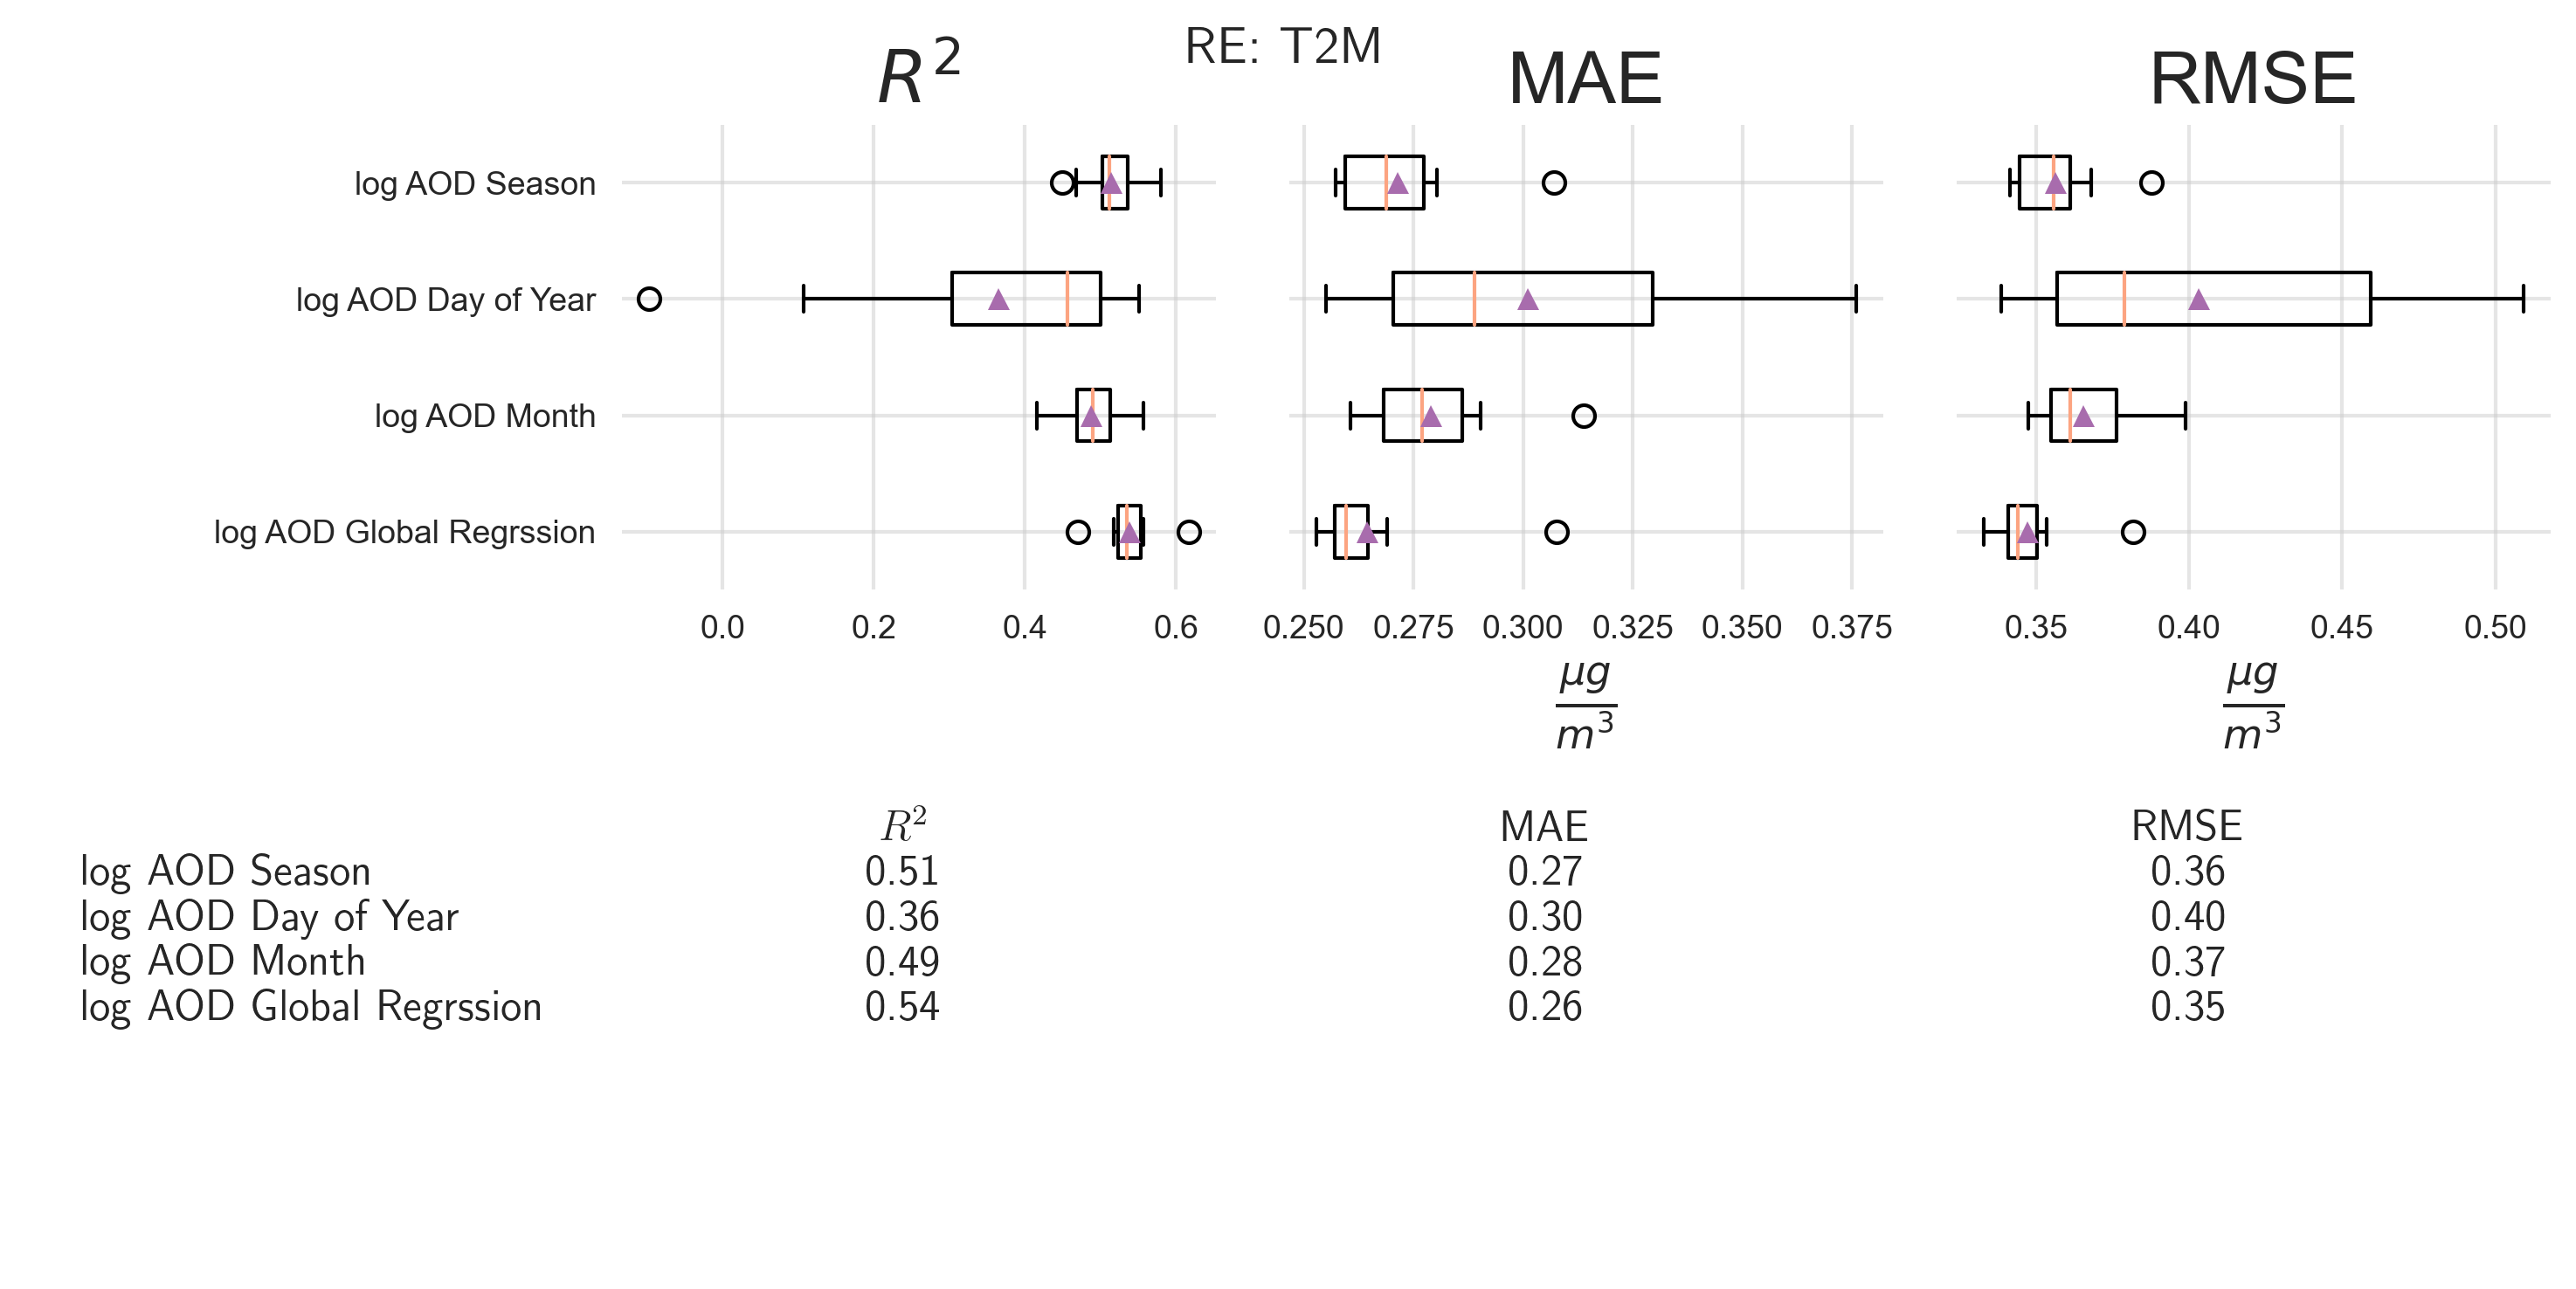

In [32]:
cv_scores = {}
# for grouping in ['season', 'doy', 'month', 'location']:
#     filename = os.path.join('models', 'lme', f'{save_prefix}{grouping}_scores.p')
#     with open(filename, 'rb') as f: 
#         scores = pickle.load(f)
#     title = grouping.capitalize()
#     if title == 'Doy':
#         title = 'Day of Year'
#     cv_scores[title] = scores['Linear Mixed Effect']
    
for grouping in ['season', 'doy', 'month']:
    filename = os.path.join('models', 'lme', f'{log_save_prefix}{grouping}_scores.p')
    with open(filename, 'rb') as f: 
        scores = pickle.load(f)
    title = grouping.capitalize()
    if title == 'Doy':
        title = 'Day of Year'
    title = 'log AOD ' + title
    cv_scores[title] = scores['Linear Mixed Effect']

# cv_scores['Global Regrssion'] = global_scores_reg["Linear Regression"]    
cv_scores['log AOD Global Regrssion'] = global_scores_log["Linear Regression"]    
    
labels, scores = map(list, zip(*cv_scores.items()))
fig, _ = grouped_boxplot_with_table(scores, labels, fs=9, save=True, filename='figures/lme_t2m_comparison.png')
fig.suptitle('RE: T2M');

In [ ]:
empty = pd.Series([], dtype='float64')

mc = ModelCollection(empty, empty)

mc.load(os.path.join('models', 'lme', f'{log_save_prefix}season.joblib'))
mc.load_model_cross_val_scores(os.path.join('models', 'lme', f'{log_save_prefix}_scores.p'))

In [58]:
from pymer4.io import save_model


save_model(mc.models['Linear Mixed Effect'].model_, 'models/lme/save.hdf5')


ValueError: unknown type: 'datetime64[ns]'

## Hyper Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params={
    'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)],
    'learning_rate': np.arange(0.5, 2, .1),
    'loss': ['linear', 'square', 'exponential'],
    'n_estimators': np.arange(10, 100, 10)
}

ada_grid = GridSearchCV(
    AdaBoostRegressor(), 
    params, 
    cv=10, 
    scoring=mc.scoring, 
    refit='neg_root_mean_squared_error',
    n_jobs=-1)

_x = x.copy()
ada_grid.fit(_x, y)

## Plotting

In [ ]:
model = mc.models['Linear Mixed Effect'].model_

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

model.plot("AODANA", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax1)
model.plot("QV2M", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax2)

ax1.set_ylim((-6, 6))
ax1.set_xlim((0, 2))

ax2.set_ylim((-6, -2.5))
ax2.set_xlim((0, .025))

(<Figure size 3000x1500 with 4 Axes>,
 (<AxesSubplot:title={'center':'$R^2$'}>,
  <AxesSubplot:title={'center':'MAE'}, xlabel='$\\frac{\\mu g}{m^3}$'>,
  <AxesSubplot:title={'center':'RMSE'}, xlabel='$\\frac{\\mu g}{m^3}$'>,
  <AxesSubplot:>))

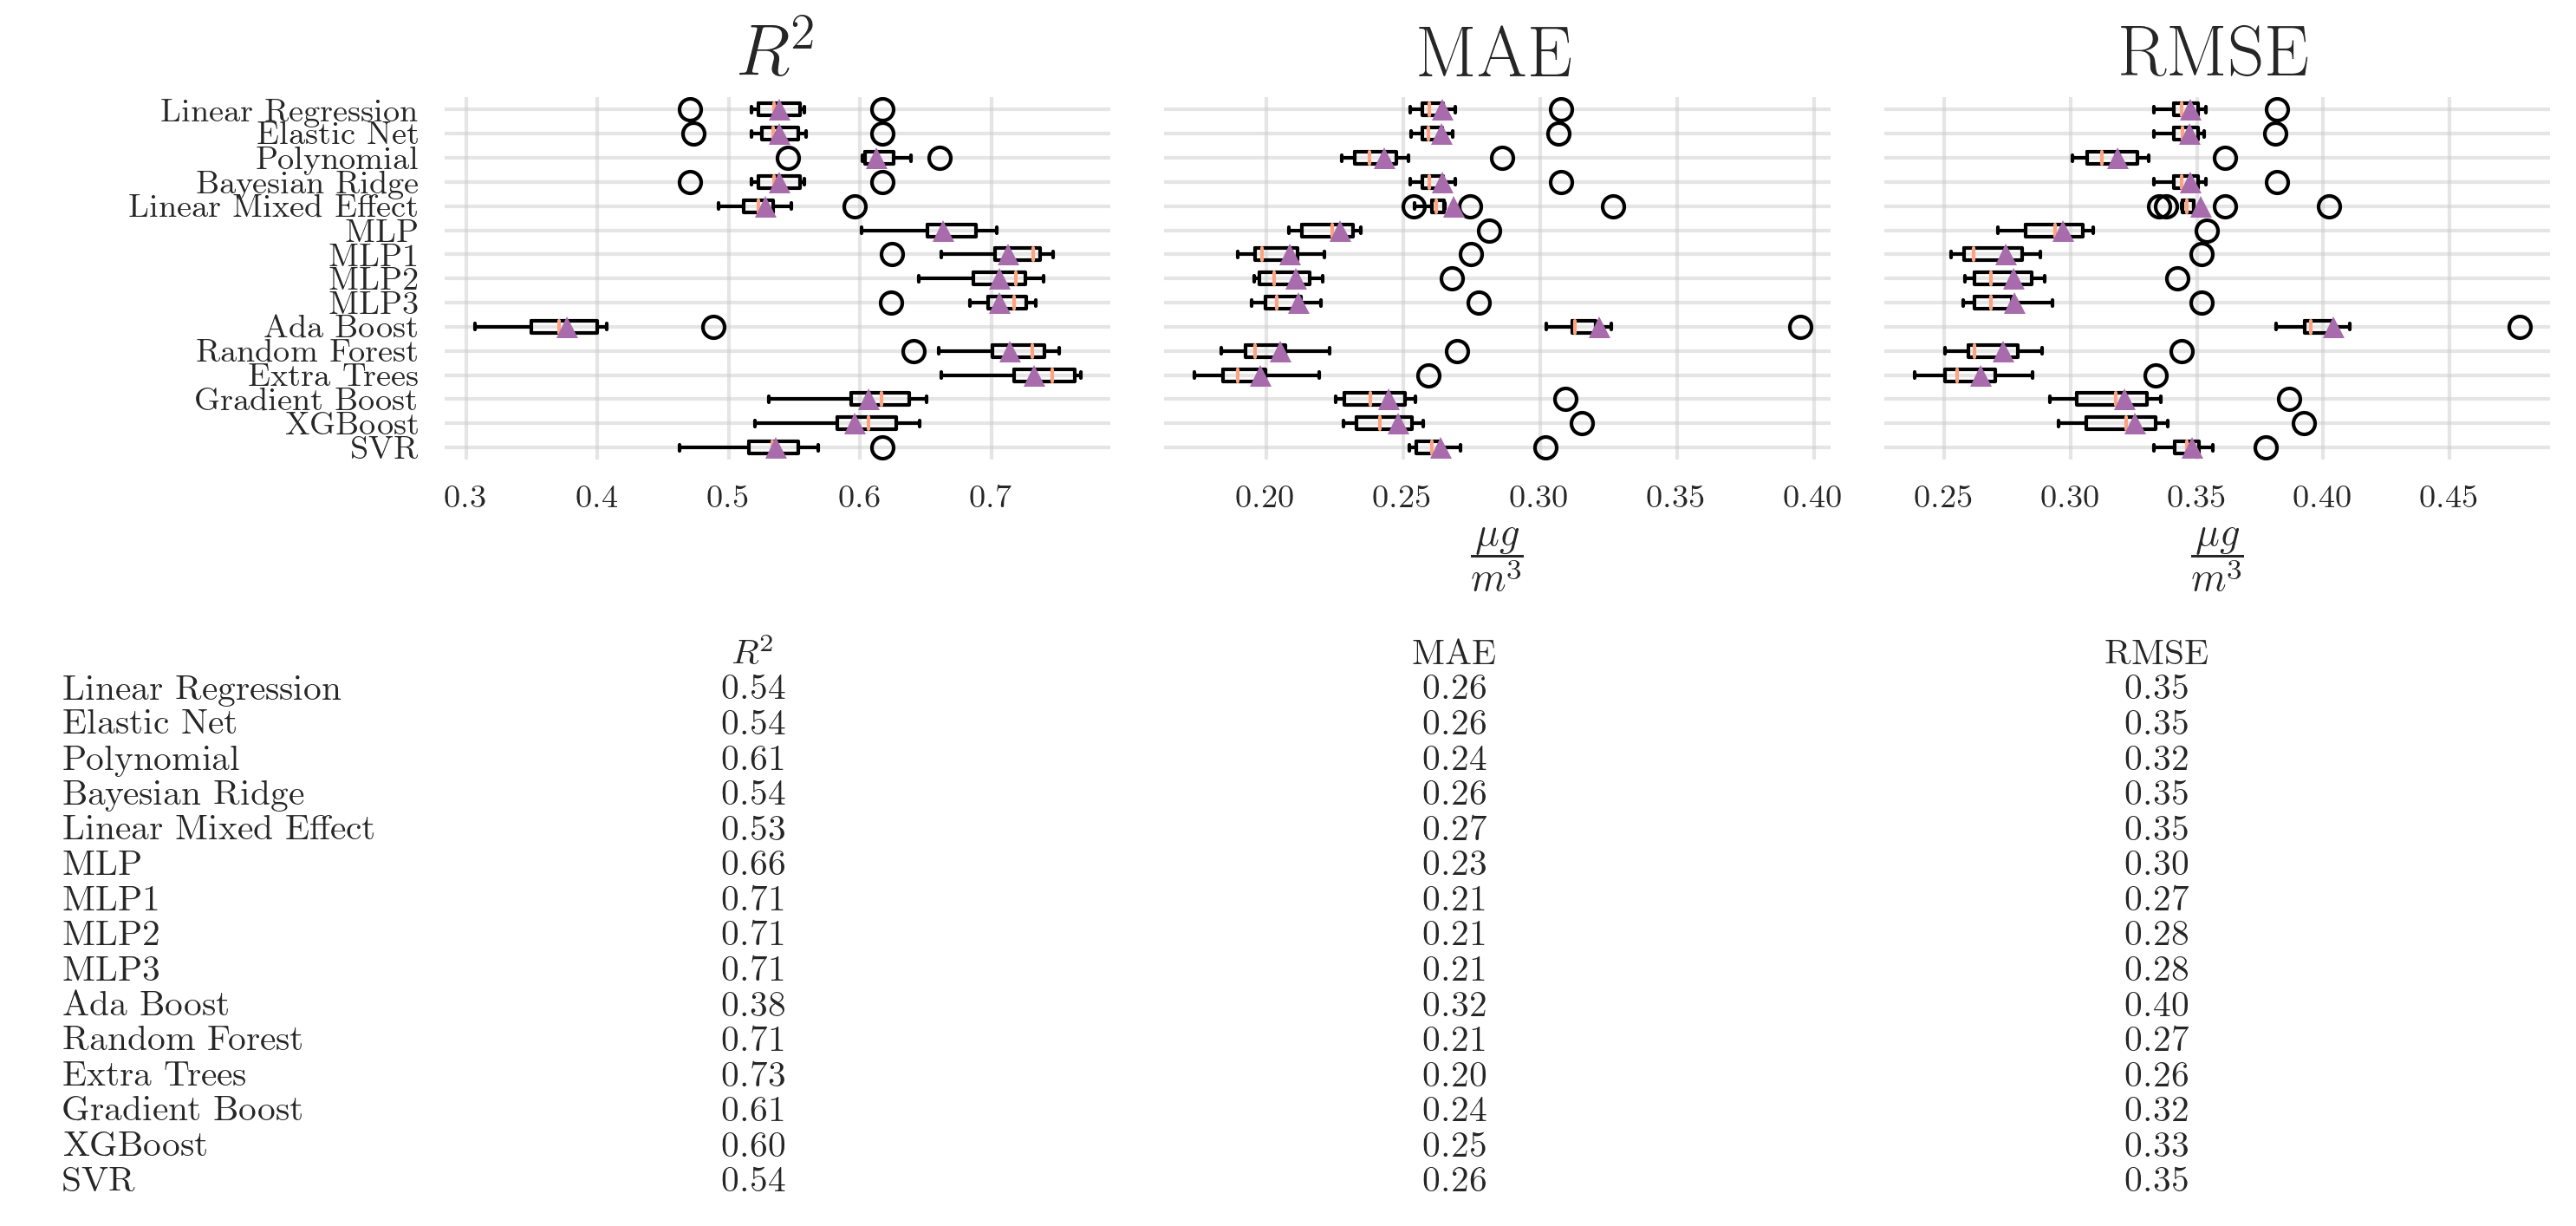

In [83]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=False, filename='scores-2010-17.png', fs=9)

In [ ]:
for name, model in mc.models.items():
    residuals_plot(model, x_train.copy(), y_train, x_val.copy(), y_val)

In [ ]:
for name, model in mc.models.items():
    plot_prediction_error(model, x_val.copy(), y_val, name=f'{name}')

In [ ]:
selected_features = ds[['QV2M', 'QV10M', 'T2M', 'T10M', 'TQV', 'AODANA', 'ALBEDO', 'TS', 'DISPH', 'PM2.5']]
avgs = selected_features.resample(time='1Y').mean()

In [ ]:
plt.rcParams.update({"text.usetex": False})

avgs[col].sel(time='2010').plot()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=300, figsize=(8.5, 11.25))

for (col, data), ax in zip(avgs.data_vars.items(), axes.ravel()):
    data.sel(time='2010').plot(ax=ax, cbar_kwargs={'label': ''})
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
fig.tight_layout()

## Stacking

In [92]:
stack = ModelStack(mc, x_train, y_train, n = 3)

In [93]:
stack.fit()

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
stack.compute_scores(x_val, y_val)

In [ ]:
plot_prediction_error(stack.voting_regressor_, x_val.copy(), y_val)

In [ ]:
stack.voting_regressor_

## Feature Importance

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
for name, model in mc.models.items():
    if getattr(model, 'feature_importances_', None) is not None:
        feature_importance(mc.models[name].feature_importances_, name, columns, fontsize=18)
        plt.savefig(f'{name}-importances-log-new-features.png')

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
for name, model in mc.models.items():
    if getattr(model, 'coef_', None) is not None:
        feature_importance(mc.models[name].coef_, name, columns, fontsize=18)
        plt.savefig(f'{name}-importances-log-new-features.png')

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
importances = mc.models['Elastic Net'].named_steps['elastic'].coef_
feature_importance(importances, 'Elastic Net', columns, fontsize=18)
plt.savefig(f'Elastic Net-importances-log-new-features.png')

In [ ]:
importances = mc.models['Polynomial'].named_steps['linear'].coef_
mask = (importances > 0.1) | (importances < -0.1)
columns = mc.models['Polynomial'].named_steps['poly'].get_feature_names(x.columns.values)
columns = np.array([f'${c}$'.replace(" ", " \cdot ") for c in columns])
feature_importance(importances[mask], 'Polynomial', columns[mask], fontsize=10)
plt.savefig(f'Polynomial-importances-log-new-features.png')

# Modeling per grid cell

In [ ]:
support = features.get_support()
# select lat, lon
support[0:2] = True

In [ ]:
x_grid = train.drop('PM2.5', axis=1).loc[:, support]
y_grid = train[['PM2.5']]

In [ ]:
train_grid = pd.concat([x_grid, y_grid], axis=1)

In [ ]:
train_grid_2010 = train_grid.loc['2010']

In [ ]:
train_grid_2011 = train_grid.loc['2011']

In [ ]:
mcs = {}

lme_group = 'Month'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

for location, data in train_grid_2010.groupby(['lat', 'lon']):
    _x, _y = data.drop(['lat', 'lon', 'PM2.5'], axis=1), data['PM2.5']
    _mc = ModelCollection(_x.copy(), 
                          _y,
                          lme_dependent='PM', 
                          lme_formula=formula, 
                          lme_group=lme_group)
    _mc.fit()
    location = str(location)
    _mc.save(f'models/locations_log_aod/{location}.joblib')
    mcs[location] = _mc

In [ ]:
import glob

mcs = {}
empty = pd.Series([], dtype=pd.StringDtype())
for file in glob.glob('models/locations/*'):
    _file_name = os.path.basename(file)
    _location = os.path.splitext(_file_name)[0]
    _mc = ModelCollection(empty, empty)
    _mc.load(file)
    mcs[_location] = _mc

In [ ]:
grid_model_predictions = {}
r2s = []
rmses = []
maes = []
locations = []
models = []

for location, data in train_grid_2011.groupby(['lat', 'lon']):
    grid_model_predictions[str(location)] = {}
    grid_model_performance[str(location)] = {}
    for _model_name, _model in mcs[str(location)].models.items():
        _x = data.copy()
        _x = _x.drop(['lat', 'lon', 'PM2.5'], axis=1)
        ypred = _model.predict(_x)
        grid_model_predictions[str(location)][_model_name] = ypred

        r2s.append(r2_score(data['PM2.5'], ypred))
        rmses.append(mean_squared_error(data['PM2.5'], ypred, squared=False))
        maes.append(mean_absolute_error(data['PM2.5'], ypred))
        locations.append(location)
        models.append(_model_name)
        

In [ ]:
all_preds = pd.DataFrame(grid_model_predictions).T

In [ ]:
pd.DataFrame({'location': locations, 'r2': r2s, 'mae': maes, 'rmse': rmses, 'model': models}).set_index(['location', 'model'])

In [ ]:
yearly_avg = all_preds.applymap(np.mean).reset_index()
coords = pd.DataFrame(yearly_avg['index'].map(eval).tolist(), index=yearly_avg.index) 
yearly_avg[['lat', 'lon']] = coords
yearly_avg = yearly_avg.drop(['index'], axis='columns').set_index(['lat', 'lon'])

In [ ]:
yearly_avg

In [ ]:
grid_true = train_grid_2011[['lat', 'lon', 'PM2.5']].reset_index().set_index(['time', 'lat', 'lon'])
grid_true = grid_true.to_xarray().resample(time='Y').mean().to_dataframe().dropna()

In [ ]:
yearly_avgs = pd.concat([yearly_avg, grid_true.groupby(['lat', 'lon']).mean()], axis=1)

# Publication Figures

In [42]:
idx = np.argsort(features.scores_)[::-1]
mi_scores = pd.DataFrame({'Features': train.drop('PM2.5', axis=1).columns.values[idx], 'Scores': features.scores_[idx]})
print(mi_scores.to_csv(index=False))

Features,Scores
AODANA,0.4069746737416189
QV10M,0.18270244382490475
T2M,0.1825537331240401
TS,0.18127149496680772
QV2M,0.1808071799266484
T10M,0.17937087420348075
TQV,0.16578580346501148
MonthCos,0.13989315698440308
ALBEDO,0.08846724742849332
DISPH,0.07616130951901301
EMIS,0.07500293959791904
TPRECMAX,0.06870892229302772
PS,0.0641359931150669
lon,0.058085481781339876
lat,0.05449727545431582
V2M,0.05205031952858086
V50M,0.04925579737327812
V10M,0.0485689751365177
TQI,0.044233604143419036
U50M,0.040058353293411564
U2M,0.03835062095618014
U10M,0.0382847785862781
TQL,0.03159941716782644
MonthSin,0.03086773046246183
CLDTOT,0.016373206188092126



In [ ]:
# labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
models = []
r2s = []
maes = []
rmses = []

for model_name, score in mc.cross_val_scores_.items():
    r2, mae, rmse = summarize_scores(score)
    models.append(model_name)
    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

In [ ]:
print(pd.DataFrame({'Model': models, 'R2': r2s, 'MAE': maes, 'RMSE': rmses}).to_csv(index=False))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

aod_only = pd.concat([x_train['AODANA'], y_train], axis=1)
aod_only['logAOD'] = aod_only['AODANA'].map(np.log)

aod_only.plot.hexbin(x='AODANA', y='PM2.5', ax=ax1)
aod_only.plot.hexbin(x='logAOD', y='PM2.5', ax=ax2, cmap='viridis')

ax1.set_ylabel('$\log PM_{2.5}$')
ax2.set_ylabel('')

ax1.set_xlabel('$AOD$')
ax2.set_xlabel('$\log AOD$')

ax.grid(False)

In [ ]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(train, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $\log PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-2, 
                       ax=ax)

plt.savefig('figures/distribution.png')

In [ ]:
predictions = pd.DataFrame(
    {
        name: model.predict(x_val.copy()) 
         for name, model in mc.models.items()
    }, index=x_val.index)

In [ ]:
predictions = pd.concat([predictions, pd.DataFrame({'True Value': y_val}, index=x_val.index)], axis=1)

In [ ]:
predictions

In [ ]:
import joypy

In [ ]:
fig, axes = joypy.joyplot(predictions, fade=True, colormap=announce, x_range=(0, 5), grid=True)

axes[-1].set_xlabel('$\ln[PM_{2.5}] ~ \mu g/m^3$')

In [ ]:
fig.savefig('figures/densities.svg', format='svg')

In [84]:
average_fit_times = {model: res['fit_time'].mean() for model, res in mc.cross_val_scores_.items()}
fit_times_error = {model: np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])) for model, res in mc.cross_val_scores_.items()}

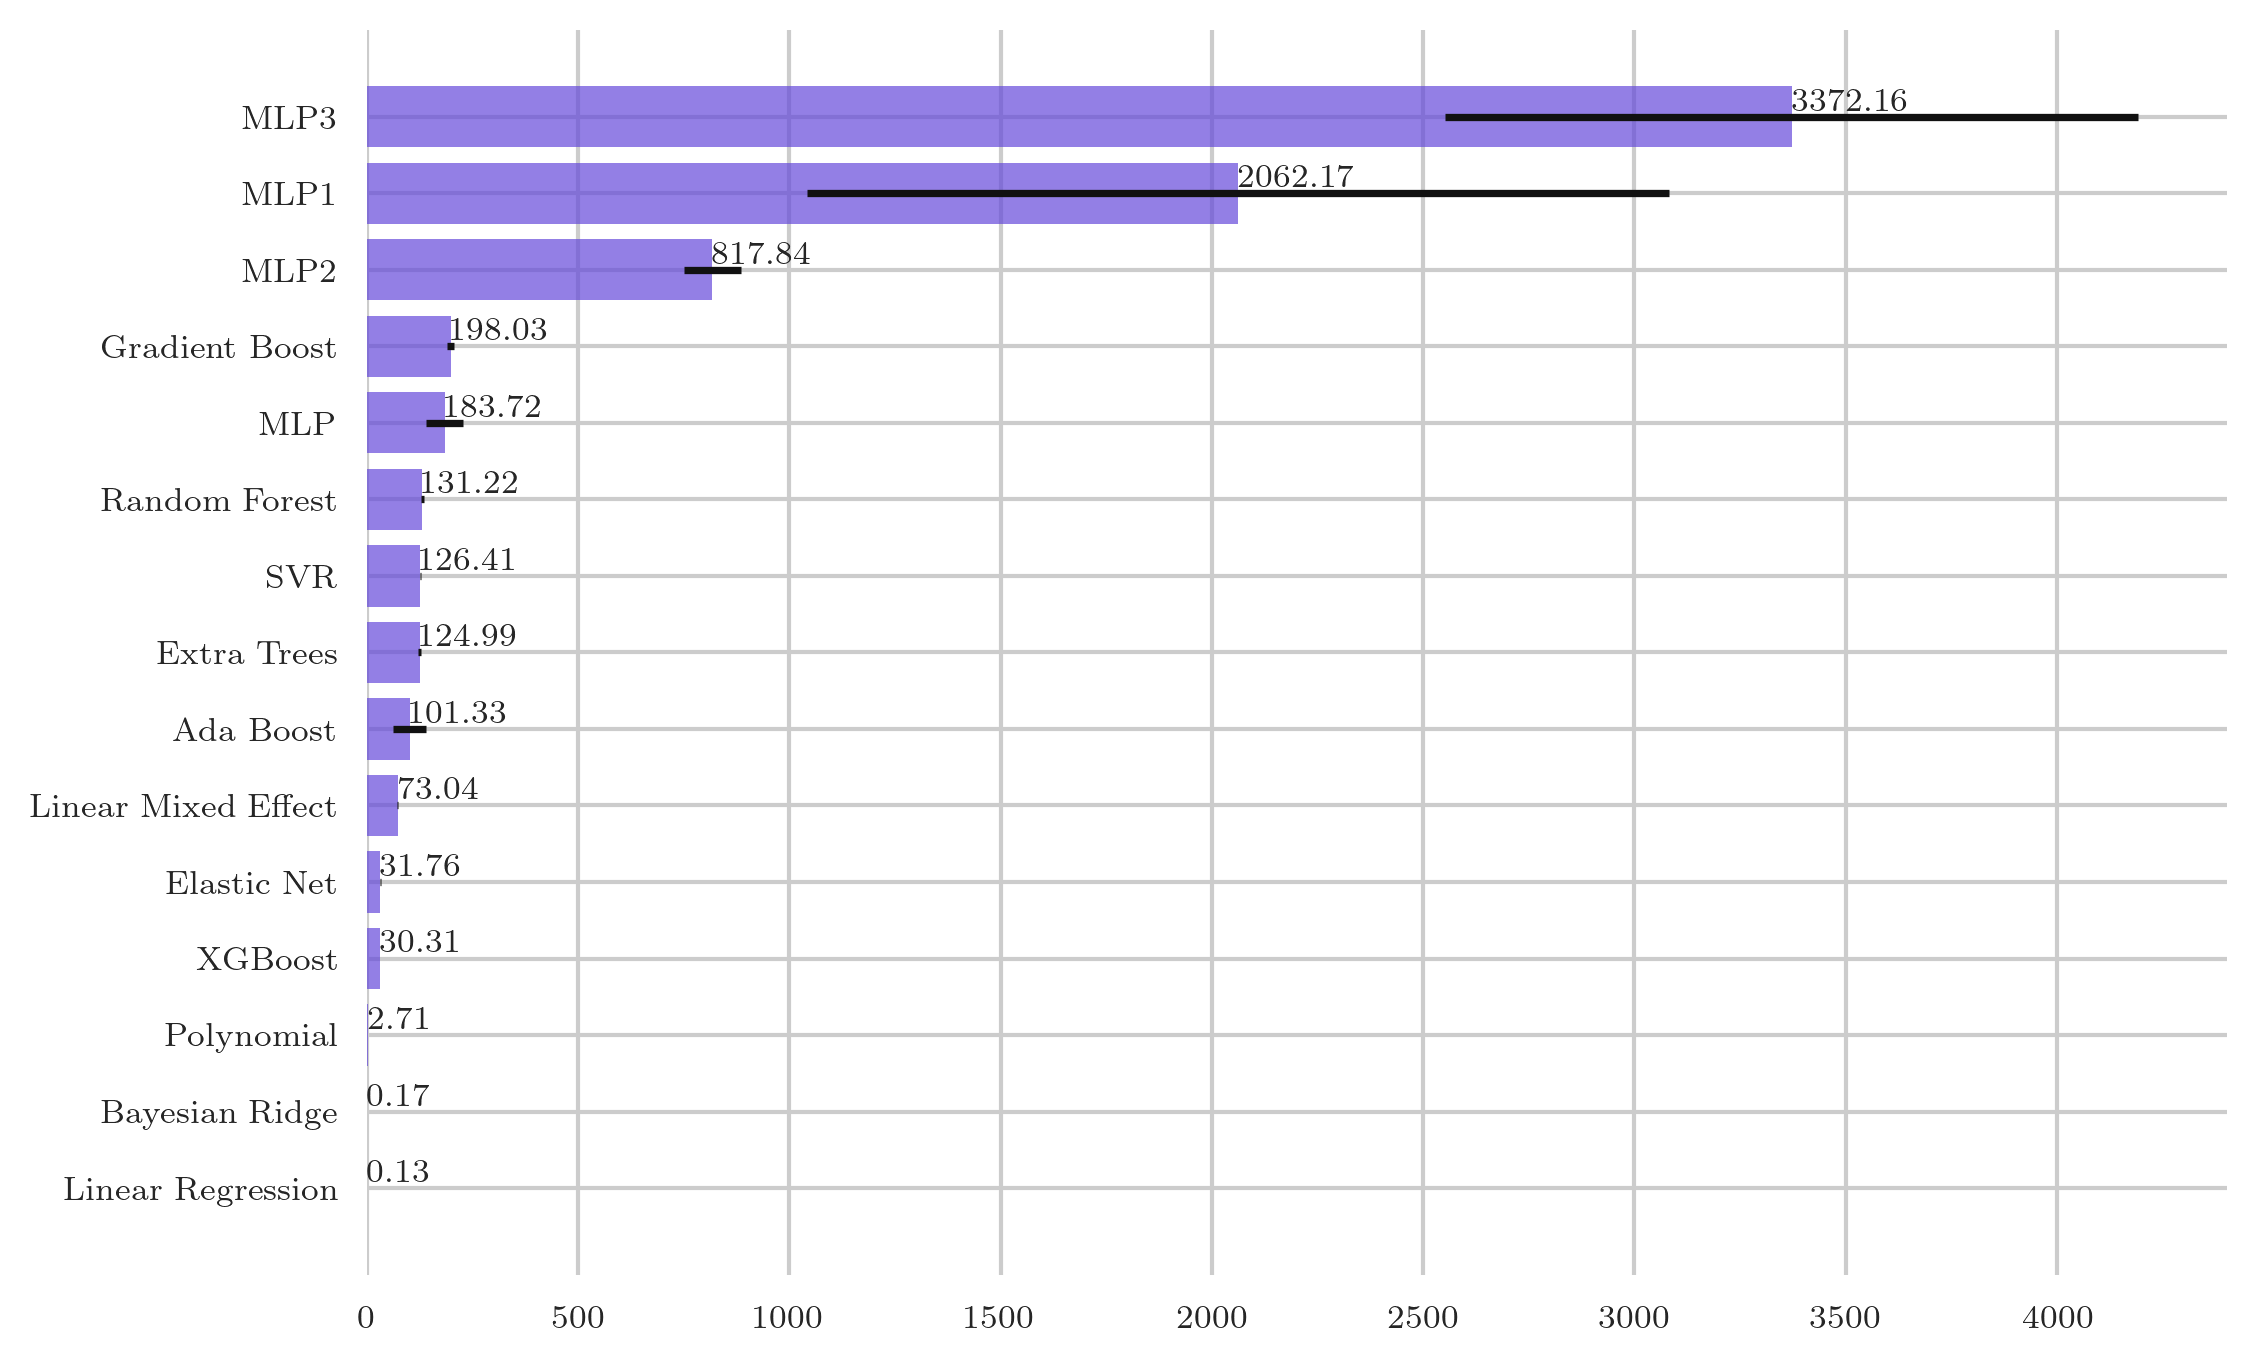

In [86]:
fig, ax = plt.subplots(dpi=300)

labels, values = map(np.array, zip(*average_fit_times.items()))
sort = np.argsort(values)

labels, values = labels[sort], values[sort]
xerr = np.array(list(fit_times_error.values()))[sort]

patches = ax.barh(labels, 
                  values, 
                  xerr=xerr,
                  alpha=0.7,
                  color='#6549DA')

for idx, patch in enumerate(patches):
    which = labels[idx]
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{average_fit_times[which]:0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
fig.savefig('figures/fit_times.svg', format='svg', bbox_inches='tight')

In [ ]:
results = pd.concat([predictions, val[['lat', 'lon']]], axis=1)
results = results.reset_index().set_index(['lat', 'lon', 'time']).to_xarray()
results = results.apply(np.exp)
results.to_netcdf('validation_results.nc4')

In [ ]:
with xr.open_dataset('validation_results.nc4') as results:
    results.load()
    
results

In [ ]:
true = results['True Value']
max_pm_occurence = true.where(true==true.max(), drop=True).squeeze().time.values
ds = results.sel(time=max_pm_occurence)

fig_title = np.datetime_as_string(max_pm_occurence, unit='D')

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/max_pm_with_predictions.svg', format='svg', bbox_inches='tight')

In [ ]:
avg_2018 = results.resample(time="Y").mean().sel(time='2018')

fig_title = '2018 Average'

fig, axes = map_predicted(avg_2018, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2018_average_predictions.svg', format='svg', bbox_inches='tight')

In [ ]:
difference_from_true_2018 = avg_2018.to_dataframe().reset_index('time').dropna().drop(['time'], axis=1)
true_series = difference_from_true_2018['True Value']
difference_from_true_2018.drop(['True Value'], axis=1, inplace=True)
cols = difference_from_true_2018.columns
difference_from_true_2018[cols] = difference_from_true_2018[cols].sub(true_series.squeeze(), axis=0)
difference_from_true_2018 = difference_from_true_2018.to_xarray()

In [ ]:
fig_title = 'Difference from the true 2018 Average'

fig, axes = map_predicted(difference_from_true_2018, nrows=3, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2018_difference_from_true_mean.svg', format='svg', bbox_inches='tight')

In [ ]:
ds = yearly_avgs.apply(np.exp).to_xarray()

fig_title = '2011 Average'

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2011_grid-by-grid_averages_log_aod.svg', format='svg', bbox_inches='tight')

# Separating data by region

In [ ]:
import geopandas as gpd
import rioxarray

In [ ]:
gdf = gpd.read_file('/Users/kyle/Downloads/tx_eco_l4/tx_eco_l4.shp')

In [ ]:
gdf = gdf.to_crs('EPSG:4326')

In [ ]:
coast = gdf.where(gdf['US_L3NAME'] == 'Western Gulf Coastal Plain')

In [ ]:
coast.plot()

In [ ]:
xr_train = train.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()

In [ ]:
xr_train.rio.set_spatial_dims('lon', 'lat', inplace=True)
xr_train.rio.write_crs('EPSG:4326', inplace=True)

clipped = xr_train.rio.clip(
    [coast.__geo_interface__['features'][0]['geometry']], 
    crs='EPSG:4326', all_touched=True
)

In [ ]:
clipped.sel(time='2010-01-01')